In [1]:
##Calling required libraries and objects 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


#gerekli ayarlamaları yapma 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
#reading data set
df = pd.read_csv("/kaggle/input/titanic/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


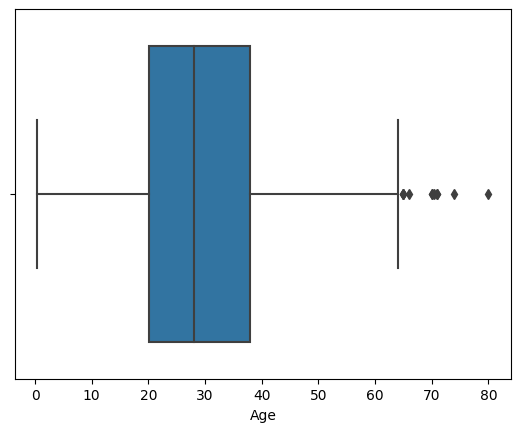

In [3]:
#Observing outliers with boxplot graph 
sns.boxplot(x=df["Age"]);

In [4]:
#We write a function to calculate the lower limit and upper limit
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75): 
    quartile1 = dataframe[col_name].quantile(q1) #Q1 value calculation
    quartile3 = dataframe[col_name].quantile(q3) #Q3 value calculation 
    interquartile_range = quartile3 - quartile1 #IQR calculation
    up_limit = quartile3 + 1.5 * interquartile_range #determination of the upper limit
    low_limit = quartile1 - 1.5 * interquartile_range #determination of the lower limit
    return low_limit, up_limit


#Let's use our function
low, up = outlier_thresholds(df, "Age") #we set the lower and upper limit

In [5]:
#accessing outliers
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name) #Determination of lower and upper limits
    
    ## If the number of observations is greater than 10, retrieve the first 5 observations
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    
    #If not, bring it all.
    else: 
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
grab_outliers(df,"Fare")

    PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch    Ticket    Fare        Cabin Embarked
1             2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0  PC 17599  71.283          C85        C
27           28         0       1                     Fortune, Mr. Charles Alexander    male 19.000      3      2     19950 263.000  C23 C25 C27        S
31           32         1       1     Spencer, Mrs. William Augustus (Marie Eugenie)  female    NaN      1      0  PC 17569 146.521          B78        C
34           35         0       1                            Meyer, Mr. Edgar Joseph    male 28.000      1      0  PC 17604  82.171          NaN        C
52           53         1       1           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female 49.000      1      0  PC 17572  76.729          D33        C


In [6]:
df[(df["Age"] < low) | (df["Age"] > up)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [7]:
#Let's write a function to query whether the variable we selected in the data frame is an outlier.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
#function is to avoid repetition when we want to query for other variables 

check_outlier(df, "Age") #Let's see if there are outliers for the age variable

True

In [8]:
#We use the gra_col_names function to specify variable types
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    #variables that are categorical are selected 
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    #variables that are numeric but categorical are selected 
    #is categorical if the number of unique classes is less than 10 (open to interpretation)
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    
    #select variables that appear categorical but are cardinal
    #cardinal if the number of unique classes is more than 20
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    #add the categorical variables we captured 
    cat_cols = cat_cols + num_but_cat 
    
    #we remove variables that appear categorical but are not categorical
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #we select numeric variables
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #we remove those that appear numerical but are categorical 
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df) #will introduce variables that are categorical, numeric and cardinal

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [9]:
num_cols

['PassengerId', 'Age', 'Fare']

In [10]:
#Let's remove the PassengerId variable because it does not provide any meaningful information 
num_cols = [col for col in num_cols if col not in "PassengerId"]
num_cols

['Age', 'Fare']

In [11]:
#We query if there is an outlier
for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [12]:
# suppressing outliers
def replace_with_thresholds(dataframe, variable):  
    # lower and upper limit calculation 
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
     # substitute the lower limit for those less than the lower limit 
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    # assign the upper limit instead of those greater than the upper limit 
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit 

In [13]:
#Let's apply the function to the numeric variables in the data set.
for col in num_cols:
    replace_with_thresholds(df, col)

In [14]:
#let's check for outliers in the dataset
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


# **Local Outlier Factor**

****

In [15]:
df = sns.load_dataset('diamonds') #loading the data set 
df = df.select_dtypes(include=['float64', 'int64']) #selecting numeric variables 
df = df.dropna() #clear missing data 
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [16]:
#query for outliers
for col in df.columns:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [17]:
#Create and fit LOF object  
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

#creating scores
df_scores = clf.negative_outlier_factor_
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

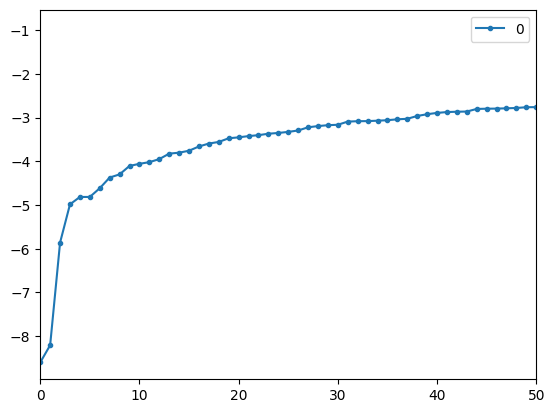

In [18]:
#graphing to determine the threshold value
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-');

In [19]:
th = np.sort(df_scores)[3]
th

-4.984151747711709

In [20]:
#select outliers based on threshold value
df[df_scores < th]

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


In [21]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800


In [22]:
#delete outliers 
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

,carat,depth,table,price,x,y,z
